<h1 align="center">Práctica 7</h1>
<h1 align="center">Resolución de un laberinto con BFS</h1>
<h3 style="display:block; margin-top:5px;" align="center">Estructuras de datos</h3>
<h3 style="display:block; margin-top:5px;" align="center">Grado en Ciencia de Datos</h3>
<h3 style="display:block; margin-top:5px;" align="center">2023-2024</h3>    
<h3 style="display:block; margin-top:5px;" align="center">Universitat Politècnica de València</h3>
<br>

**Pon/poned aquí tú/vuestros nombre(s):**
- Pablo Pertusa Canales

## Índice
- ### [Introducción y objetivos](#intro)
- ### [Actividad 1: Recorrer pasillos del laberinto con BFS](#act1)
- ### [Actividad 2: Pintar el camino más corto](#act2)

<a id='intro'></a>
## Introducción: Objetivos de la práctica

El objetivo de esta práctica es utilizar el [recorrido primero en anchura o BFS (Breadth First Search)](https://es.wikipedia.org/wiki/B%C3%BAsqueda_en_anchura) para encontrar la mejor solución en un laberinto.

Nos podremos mover únicamente en horizontal o en vertical y siempre por casillas de color blanco (las paredes son de color negro).

La calidad de una solución se mide por el número de movimientos realizados.

Es posible que exista más de una solución óptima (caminos que empatan en longitud), pero cualquier solución óptima es igual de buena.

Para recorrerlo utilizaremos BFS que tiene la propiedad de ir visitando los vértices de menor distancia cuando medimos la distancia en nº aristas (si tienen pesos hay que utilizar otros algoritmos como Dijkstra (si no hay pesos positivos), Bellman-Ford, etc.).

Hemos generado las imágenes de los laberintos utilizando la siguiente página (por si quieres generar más laberintos para otras pruebas):

https://keesiemeijer.github.io/maze-generator/#generate

Es importante poner el parámetro  `Wall thickness:` a 1.

## Cómo cargar y manipular imágenes con la biblioteca `PIL.Image`:

El módulo `PIL` [(ver el siguiente enlace)](https://pillow.readthedocs.io/en/stable/) permite cargar, manipular y guardar imágenes en diferentes formatos. Veamos cómo cargar una imagen, lo primero es importarlo:

In [1]:
import matplotlib.pyplot as plt
from PIL import Image

Ahora vamos a utilizar la clase `Image` de la biblioteca [PIL](https://pillow.readthedocs.io/en/3.1.x/reference/Image.html). Lo más sencillo es cargar una imagen con `Image.open`:

<class 'PIL.PngImagePlugin.PngImageFile'>
<class 'PixelAccess'>


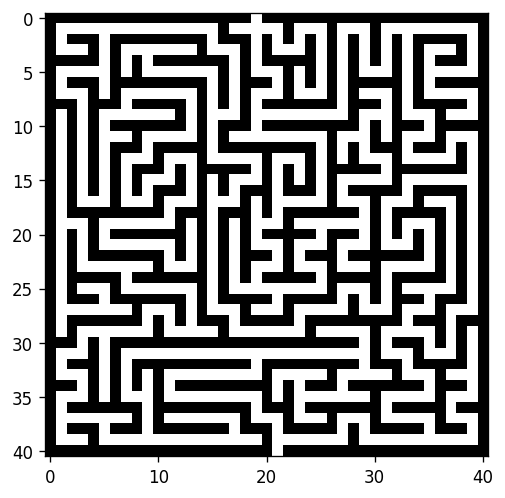

In [2]:
%matplotlib inline
img = Image.open("maze.png")
plt.figure(dpi=120) # para que lo muestre un poco más grande
plt.imshow(img)
print(type(img))
p = img.load() # pixel access
print(type(p))

Veamos cómo se puede obtener el tamaño de la imagen:

In [3]:
width, height = img.size
print(f'imagen de talla {width} de ancho por {height} de alto')

imagen de talla 41 de ancho por 41 de alto


Podemos consultar el contenido de la imagen con el método `getpixel` o directamente con `[x,y]` aplicado a un objeto *pixel access*. El método `getpixel` recibe un sólo parámetro con una coordenada (una tupla `(x,y)`). Las coordenadas `(x,y)` son:

- `x` coordenada horizontal (empezando por la izquierda) entre `0` y `width-1`.
- `y` coordenada vertical (empezando arriba) entre `0` y `height-1`.

En ambos casos obtenemos un valor (una tupla) que depende del modo de la imagen. Para ver el modo de la imagen podemos hacer esto:

In [4]:
print(f'imagen con modo {img.mode}')

imagen con modo RGBA


Al tratarse del modo RGBA cada pixel vendrá dado por una tupla con 4 valores:

In [5]:
coordenada = (20,10)
pixel = img.getpixel(coordenada)
print(pixel) # (0, 0, 0, 255) es negro
pixel = p[10,21] # otra forma, usando p que es un pixel access de img
print(pixel) # (255, 255, 255, 255) es blanco

(0, 0, 0, 255)
(255, 255, 255, 255)


En el siguiente ejemplo puedes ver cómo se puede pintar una imagen utilizando el método `putpixel` o bien directamente con el *pixel access*:

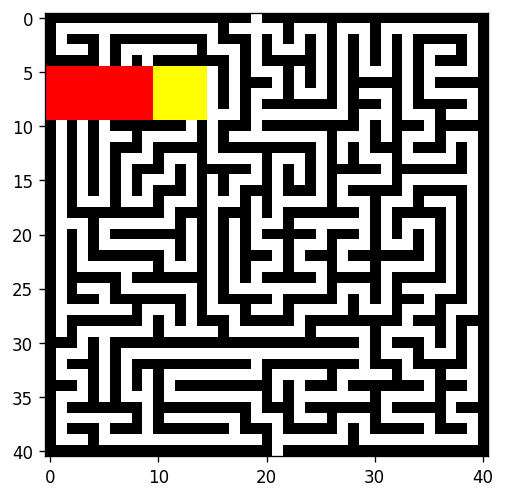

In [6]:
white  = (255, 255, 255, 255)
black  = (  0,   0,   0, 255)
red    = (255,   0,   0, 255)
yellow = (255, 255,   0, 255)

for y in range(5,10): # vertical desde arriba
    for x in range(10): # horizontal desde izquierda
        img.putpixel((x,y),red)
    for x in range(10,15):
        p[x,y] = yellow # otra forma de pintar

plt.figure(dpi=120) # para que lo muestre un poco más grande
plt.imshow(img)
None

<a id='act1'></a>
## Actividad 1: Recorrer pasillos del laberinto con BFS.

Se trata de adaptar el algoritmo BFS visto en clase para que en lugar de ser un método de la clase `DiGraph` sea una función que recibe:

- `img` la imagen del laberinto
- `entrada` es una tupla con las coordenadas de la entrada del laberinto.
- `salida` es una tupla con las coordenadas de la salida del laberinto.

El algoritmo utiliza:

- Un diccionario `dist` que asocia a cada coordenada visitada la distancia (en nº aristas, en nuestro caso movimientos horizontal/vertical) desde la entrada.
- Un diccionario `prev` que a cada coordenada visitada le indica la coordenada de donde venía.
- `Q` es una cola FIFO similar a la utilizada en el BFS de teoría, es un objeto de la clase `collections.deque()`.
- **NO** vamos a utilizar `visited`, en su lugar vamos a pintar los pixels visitados de color `yellow`.

Al no haber un grafo explícitamente hablando:

- las coordenadas de pixels de color `while` hacen el papel de vértices.
- cada coordenada puede tener entre 0 y 4 adyacentes dependiendo de si la coordenada adyacente está dentro de la imagen (por ejemplo, en la primera fila no hay adyacentes arriba porque te sales de la imagen).
- si un pixel no es blanco no lo vamos a visitar.
- al visitar un pixel lo hemos de pintar de color `yellow` para indicar que ya ha sido visitado.

Al terminar hemos de devolver los diccionarios `prev` y `dist`.


In [20]:
import collections

def BFS_maze( img, entrada, salida ):
    """
    Recibe:
    
    img: el laberinto como imagen.
    entrada: coordenada de la entrada del laberinto
    salida: coordenada de la salida del laberinto
    
    Realiza un recorrido en BFS desde la entrada hasta no poder continuar
    o bien hasta visitar la salida.
    
    Pinta en color amarillo los pasillos recorridos.
    """
    white  = (255, 255, 255, 255)
    yellow = (255, 255,   0, 255)
    
    width, height = img.size
    p = img.load() # podemos usar p[x,y] para leer o escribir colores
    
    prev = {}
    dist = {}
    Q = collections.deque()
    Q.append(entrada)
    p[entrada] = yellow
    found = False
    dist[entrada] = 0
    while not found:
        (x,y) = Q.popleft()

        vecinos = []
        # meter en vecinos las 4 coordenadas adyacentes a (x,y)
        # que no se salgan de la imagen
        #
        # los vecinos se insertan en orden:
        # izquierda, derecha, arriba, debajo
        # COMPLETAR
        if x-1 >= 0:
            if p[x-1,y] == white:
                vecinos.append((x-1,y))
        if x+1 < width:
            if p[x+1,y] == white:
                vecinos.append((x+1,y))
        if y-1 >= 0:
            if p[x,y-1] == white:
                vecinos.append((x, y-1))
        if y+1 < height:
            if p[x,y+1] == white:
                vecinos.append((x,y+1))
        
        for (x2,y2) in vecinos:
            # COMPLETAR bucle interno de BFS
            # actualizando found para que pare
            # en cuanto se visite el vértice salida
            p[x2,y2] = yellow
            Q.append((x2,y2))
            prev[(x2,y2)] = (x,y)
            dist[(x2,y2)] = dist[(x,y)]+1
            if (x2,y2) == salida:
                found = True
                

    return prev,dist

Y lo probamos con la imagen anterior, para ello creamos una función auxiliar que localiza la entrada y la salida suponiendo que la entrada está en la primera fila y la salida en la última:

El camino más corto es de longitud 138


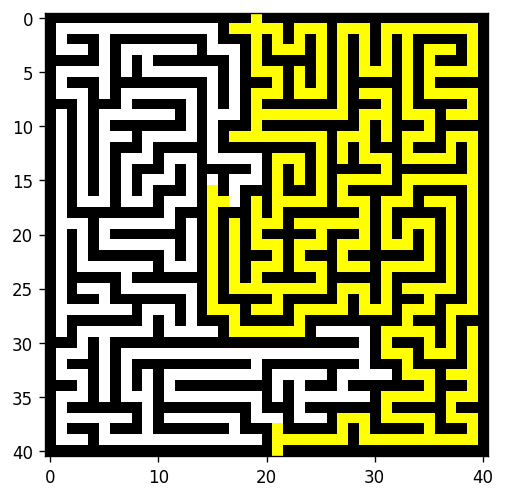

In [21]:
img = Image.open("maze.png")

def calcula_entrada( img ):
    white = (255, 255, 255, 255)    
    width, height = img.size
    p = img.load() # podemos usar p[x,y] para leer o escribir colores
    for x in range(width):
        if p[x, 0] == white:
            return (x,0)
        
def calcula_salida( img ):
    # COMPLETAR
    white = (255, 255, 255, 255)    
    width, height = img.size
    p = img.load() # podemos usar p[x,y] para leer o escribir colores
    for x in range(width):
        if p[x, height-1] == white:
            return (x,height-1)

entrada = calcula_entrada( img )
salida  = calcula_salida( img )
prev,dist = BFS_maze( img, entrada, salida )

plt.figure(dpi=120) # para que lo muestre un poco más grande
plt.imshow(img)
print('El camino más corto es de longitud',dist[salida])

<a id='act2'></a>
## Actividad 2: Pintar el camino más corto

Para pintar el camino más corto partimos de la coordenada de salida y vamos retrocediendo utilizando el diccionario `prev`. Cada pixel visitado en ese recorrido se pintará de color `red`.

Se aconseja utilizar un bucle `while`.

Observa que no basta con pintar un pixel dentro del bucle `while` ya que te dejarás probablemente la entrada o la salida por pintar. Has de pintar el extremo que falte fuera del bucle.

In [26]:
def recuperar_camino( img, prev, salida ):
    """
    Esta función no devuelve nada.
    Se limita a pintar en color red los pixels del camino del laberinto
    a partir del diccionario prev (calculado por BFS) y de la coordenada
    de salida.
    """
    red = (255,   0,   0, 255)
    p = img.load() # podemos usar p[x,y] para leer o escribir colores
    # COMPLETAR
    p[salida] = red
    ant = prev[salida]
    while ant in prev:
        p[ant] = red
        ant = prev[ant]
    p[ant] = red
    

Vamos a probar a pintar el camino del ejemplo calculado anteriormente con `BFS_maze`:

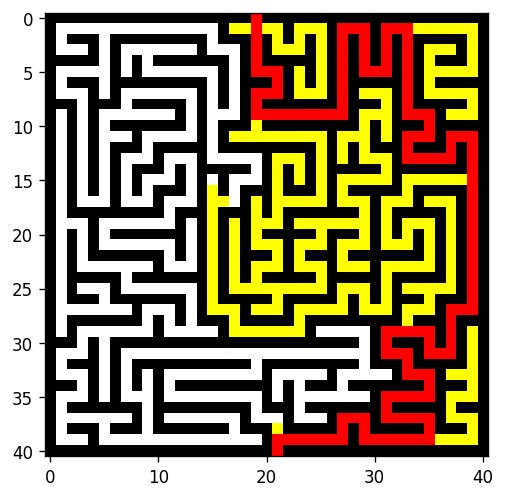

In [27]:
recuperar_camino( img, prev, salida )

plt.figure(dpi=120) # para que lo muestre un poco más grande
plt.imshow(img)
None

La última actividad consiste en agrupar todo lo ejecutado anteriormente en una función que recibe el nombre del fichero que contiene un laberinto y que muestra por pantalla un mensaje con la longitud del camino al tiempo que pinta el laberinto con el camino en rojo superpuesto a la zona explorada por BFS en amarillo:

In [34]:
def solucionar_laberinto(filename):
    img = Image.open(filename)
    entrada = calcula_entrada(img)
    salida = calcula_salida(img)
    prev, dist = BFS_maze(img, entrada, salida)
    print('El camino más corto es de longitud',dist[salida])
    recuperar_camino(img, prev, salida)
    plt.figure(dpi=120)
    plt.imshow(img)


Veamos un par de ejemplos un poco más grandes:

El camino más corto es de longitud 2726


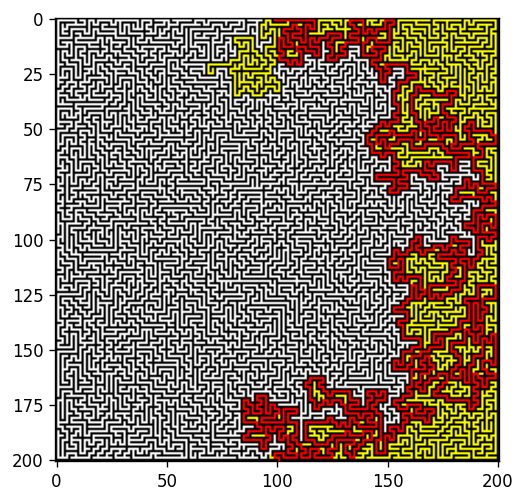

In [37]:
solucionar_laberinto('mazebig1.png')

El camino más corto es de longitud 3242


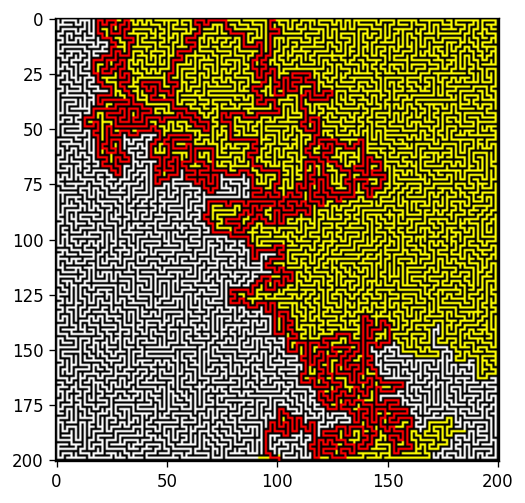

In [38]:
solucionar_laberinto( 'mazebig2.png' )